Script for training a PINNs model for the simple pendulum - **Forward Problem**


$\dfrac{d^2 x}{d t^2} +  \dfrac{g}{l} \sin(x) = 0~,$

IC: $x(0) = A,~~\dfrac{d x}{d t}|_{t=0} = 0$



$~\omega_0 = \sqrt{\dfrac{g}{l}}~$

Instead of using an analytical solution for this differential equation, we use an ODE solver to numerically solve the ODE and create training and testinf data for the PINN.

# Import libraries and modules

In [7]:
import math
import os
import shutil

# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np
# from scipy.interpolate import CubicSpline, PchipInterpolator, Akima1DInterpolator, make_interp_spline, interp1d

from tensorflow import keras
import keras.backend as K
from tensorflow.keras.layers import Activation, Dense, InputLayer, Lambda
from scipy.integrate import solve_ivp

# Set data type
DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)

import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display

# Set random seed for reproducible results
np.random.seed(2023)
tf.random.set_seed(3202)

from tensorflow.keras.optimizers import Adam, SGD, RMSprop

# # tf.config.experimental_run_functions_eagerly(True)
# tf.config.run_functions_eagerly(True)

# Install the pyDOE module
from pyDOE import lhs   ##https://pythonhosted.org/pyDOE/randomized.html

# from google.colab import drive
# drive.mount('/content/gdrive')

## Create folder for Output Files (input for next steps)
plots_folder_list = ['plots_training', 'plots_final']

# Check if the folder exists
if os.path.exists(plots_folder_list[0]):
    # If it exists, delete it and its contents
    shutil.rmtree(plots_folder_list[0])
# Create the folder
os.mkdir(plots_folder_list[0])

## Create folder for Output Files (input for next steps)
try:
    os.mkdir(plots_folder_list[1])
except OSError as error:
    # print(error)
    print(f"Folder '{plots_folder_list[1]}' already existed.")

Folder 'plots_final' already existed.


# Parameterns and constants

In [8]:
# Set number of data points
NP_train = 60   ## to compare to the ground truth
NP_coll = 200    ## to substitute the differential equation
NP_test = 2000


# Initial Condition
X0 = 1.0
V0 = 0.0
Y0 = [X0, V0]

# Set boundary
TMIN = 0.0
TMAX = 5.0

COEFF_G  = 9.81     #m/s^2
COEFF_L  = 1.0      #m


COEFF_w0 = math.sqrt(COEFF_G / COEFF_L)
DATA_RANGE = 0.4

SCL_LOSS_train = 1e0
SCL_LOSS_coll  = 1e0  #1e-4  #0.0
SCL_LOSS_ic1   = 1e0
SCL_LOSS_ic2   = 1e0

HIDDEN_LAYERS = [32, 32, 32]
LENGTH = len(HIDDEN_LAYERS)
EPOCHS = PATIENCE = 150001   #650001 2001 # number of training loop runs
BATCH_SIZE = None

# PATIENCE = 300001
MIN_DELTA = 1e-6
CHEB = False

SAVE_FIG_STEP = EPOCHS // 40
ODE_MODEL = 'SP'

# General functions

In [9]:
def analytic_sol(t, w0=COEFF_w0, X0=X0):
    """
    Calculate the analytical solution for a 1D underdamped harmonic oscillator problem.

    Args:
        t (float or numpy.ndarray): Time or an array of time values.
        d (float, optional): Damping coefficient (default is COEFF_d).
        w0 (float, optional): Angular frequency (default is COEFF_w0).
        X0 (float, optional): Initial displacement (default is X0).

    Returns:
        float or numpy.ndarray: Displacement as a function of time 't'.

    Raises:
        AssertionError: If 'd' is greater than or equal to 'w0', which violates the underdamped condition.

    Notes:
        This function computes the displacement of an underdamped harmonic oscillator as a function of time
        based on the given parameters 'd', 'w0', and 'X0'. The equation used is derived from the harmonic
        oscillator problem.

    References:
        Equations derived from: https://beltoforion.de/en/harmonic_oscillator/"""

    x = X0 * np.cos(w0 * t)
    return x


def plot_results(t_coll, t_train, t_test, y_pred, y_train, y_test, y_pred_best=None, epoch=EPOCHS):
    """
    Plot the results of a neural network model for solving a physical problem.

    Args:
        t_coll (numpy.ndarray): Time values for collocation points.
        t_train (numpy.ndarray): Time values for training data.
        t_test (numpy.ndarray): Time values for test data.
        y_pred (numpy.ndarray): Predicted values from the neural network for test points.
        y_train (numpy.ndarray): Solutions from the ODE solver for training data.
        y_test (numpy.ndarray): Solutions from the ODE solver for test data.
        y_pred_best (numpy.ndarray, optional): Predicted values from the neural network with the best weights
            (default is None).
        epoch (int, optional): Current training step or epoch number (default is EPOCHS).

    Note:
        This function generates a plot to visualize the results of a neural network model trained to
        solve a physical problem. It plots the neural network predictions, analytical solutions, training
        data, and collocation points at a given training step or epoch. Optionally, it can also plot predictions
        made with the best weights if provided in the `y_pred_best` argument.
    """


    plt.figure(figsize=(10, 6))  # Adjust the width and height as needed

    # Plot the other data in the second subplot (ax2)
    plt.plot(t_test, y_test[:,0].reshape(-1,1), color='g', linewidth=4, alpha=0.8, label='Exact angle and velocity')
    plt.scatter(t_train, y_train[:,0].reshape(-1,1), s=70, color='r', alpha=0.5, label='Training angle and velocity')
    plt.plot(t_test, y_test[:,1].reshape(-1,1), color='g', linewidth=4, alpha=0.8)
    plt.scatter(t_train, y_train[:,1].reshape(-1,1), s=70, color='r', alpha=0.5)
    plt.scatter(t_coll, [0] * len(t_coll), s=30, color='tab:blue', alpha=0.8, label='Collocation points')

    if y_pred_best is None:
        plt.plot(t_test, y_pred[:,0].numpy().reshape(-1,1), color='b', linewidth=3, linestyle='--', alpha=0.8, label='NN angle and velocity prediction')
        plt.plot(t_test, y_pred[:,1].numpy().reshape(-1,1), color='b', linewidth=3, linestyle='--', alpha=0.8)
    else:
        # plt.plot(t_test, y_pred[:,0].numpy().reshape(-1,1), color='tab:blue', linewidth=3, linestyle='--', alpha=0.8, label='NN angle prediction (final)')
        plt.plot(t_test, y_pred_best[:,0].numpy().reshape(-1,1), color='b', linewidth=3, linestyle='--', alpha=0.8, label='NN angle and velocity prediction (best)')
        # plt.plot(t_test, y_pred[:,1].numpy().reshape(-1,1), color='tab:blue', linewidth=3, linestyle='--', alpha=0.8, label='NN velocity prediction (final)')
        plt.plot(t_test, y_pred_best[:,1].numpy().reshape(-1,1), color='b', linewidth=3, linestyle='--', alpha=0.8)

    if y_pred_best is None:
        plt.title(f"Training step {epoch}", fontsize="xx-large")

    plt.xlabel('$time (s)$', fontsize="x-large")
    plt.ylabel('$\\theta$ (radian) and velocity ($m$)', fontsize="x-large")
    plt.tick_params(labelsize="large")
    plt.legend(loc='upper right', frameon=False, fontsize="large")


class SaveBestWeights(tf.keras.callbacks.Callback):
    """
    Callback to save the best weights of a Keras model during training.

    Args:
        model (tf.keras.Model): The Keras model whose weights are to be saved.
        monitor (str, optional): The metric to monitor for improvement (default is 'loss').
        mode (str, optional): The direction of improvement ('min' for lower values, 'max' for higher values, default is 'min').
        save_best_only (bool, optional): If True, only save the best weights (default is True).
        save_weights_only (bool, optional): If True, save only the weights; if False, save the entire model (default is True).
        verbose (int, optional): Verbosity level (0 for silent, 1 for informative messages, default is 1).

    Attributes:
        best_weights: The best weights of the model.
        best_metric: The best value of the monitored metric.
    """

    def __init__(self, model, monitor='loss', mode='min', save_best_only=True, save_weights_only=True, verbose=1):

        super(SaveBestWeights, self).__init__()

        self.tracked_model = model
        self.monitor = monitor
        self.mode = mode
        self.save_best_only = save_best_only
        self.save_weights_only = save_weights_only
        self.verbose = verbose
        self.best_weights = None
        self.best_metric = float('inf') if mode == 'min' else float('-inf')

    def on_epoch_end(self, epoch, logs=None):
        """
        Called at the end of each epoch to check if the model's metric has improved.

        Args:
            epoch (int): The current epoch number.
            logs (dict): Dictionary containing the monitored metric value.

        Note:
            This method compares the monitored metric with the best metric value seen so far and saves
            the model's weights if the metric has improved. The direction of improvement is determined
            by the 'mode' attribute ('min' for lower values, 'max' for higher values).
        """

        current_metric = logs.get(self.monitor)
        if current_metric is None:
            if self.verbose > 0:
                print(f"Warning: Metric '{self.monitor}' is not available. Best weights not saved.")
            return

        if self.mode == 'min':
            improved = current_metric < self.best_metric
        else:
            improved = current_metric > self.best_metric

        if improved:
            self.best_metric = current_metric
            if self.save_weights_only:
                self.best_weights = self.tracked_model.get_weights()
            else:
                self.best_weights = self.tracked_model

    def on_train_end(self, logs=None):
        """
        Called at the end of training to restore the best weights to the model.

        Args:
            logs (dict): Not used in this method.

        Note:
            This method is called at the end of training and restores the best weights to the model
            if they were saved. It also provides an optional verbose message indicating that the training
            has finished and the best weights are being restored.
        """

        if self.best_weights is not None:
            if self.verbose > 0:
                print("Training finished. Restoring best weights.")
            if self.save_weights_only:
                self.tracked_model.set_weights(self.best_weights)
            else:
                self.tracked_model = self.best_weights


def save_gif_PIL(outfile, files, fps=4, loop=3):
    """
    Helper function for creating GIFs.

    Args:
        outfile (str): The name of the output GIF file.
        files (List[str]): List of file paths containing image frames for the GIF.
        fps (int, optional): Frames per second for the GIF (default is 4).
        loop (int, optional): Number of times the GIF should loop (0 for infinite loop, default is 3).

    Returns:
        PIL.Image.Image: The saved GIF image.

    Note:
        This function takes a list of image files, combines them into a GIF animation, and saves it
        with the specified name and parameters. It returns the saved GIF as a PIL Image object.
    """

    imgs = [Image.open(file) for file in files]
    img0 = imgs[0]
    outfolder = os.path.join(plots_folder_list[1], outfile)
    img0.save(outfolder, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)

    return Image.open(outfolder)


def chebyshev_nodes(N):
    k = np.arange(1, N + 1)
    nodes = np.cos((2 * k - 1) * np.pi / (2 * N))
    return nodes.reshape(-1, 1)

# Set data points

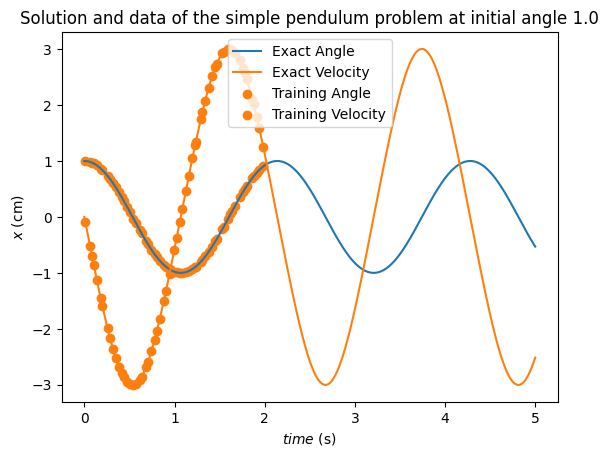

In [10]:
def simple_pendulum_dynamics(t, y):
    x, v = y[0], y[1]  # Position x and velocity v
    dxdt = v
    dvdt = -(COEFF_G / COEFF_L) * np.sin(x)
    return [dxdt, dvdt]

true_y0 = [X0, V0]  # Initial state [position, velocity]


# get the analytical solution over the full domain
t_test = np.linspace(0, TMAX, NP_test).reshape(-1,1)
t_test = np.sort(t_test, axis=0)
solution = solve_ivp(
    fun=simple_pendulum_dynamics,       # The ODE function
    t_span=(t_test[0], t_test[-1]),     # Time span (start, end)
    y0=true_y0,                         # Initial conditions
    t_eval=t_test.flatten(),            # Points at which to store the solution
    method='DOP853',                    # Explicit Runge-Kutta method of order 8
    rtol=1e-8,                          # Set relative tolerance (example value)
    atol=1e-10 
)

y_test = (solution.y.T)
x_test = (solution.y.T)[:,0].reshape(-1,1)
v_test = (solution.y.T)[:,1].reshape(-1,1)

# slice out a small number of points from the LHS of the domain
t_train = t_test[0] + (t_test[int(DATA_RANGE*(NP_test-1))] + t_test[0]) * lhs(1, samples=NP_train)
# t_train = t_test[0] + (t_test[-1] - t_test[0]) * lhs(1, samples=NP_train)
t_train = np.sort(t_train, axis=0)
solution = solve_ivp(
    fun=simple_pendulum_dynamics,  # The ODE function
    t_span=(t_test[0], t_test[-1]),         # Time span (start, end)
    y0=true_y0,                   # Initial conditions
    t_eval=t_train.flatten(),                     # Points at which to store the solution
    method='DOP853',               # Explicit Runge-Kutta method of order 8
    rtol=1e-8,                          # Set relative tolerance (example value)
    atol=1e-10 
)

y_train = (solution.y.T)
x_train = (solution.y.T)[:,0].reshape(-1,1)
v_train = (solution.y.T)[:,1].reshape(-1,1)

# Define the standard deviation of the noise
# noise_stddev = X0 * 0.1  # 10% of A
# Generate random noise of the same shape as x_train
# noise = np.random.normal(0, noise_stddev, x_train.shape)
# Add the noise to the training data
# x_train = x_train + noise

# Collcation points for the differential equation
t_coll = np.linspace(0, TMAX, NP_coll).reshape(-1, 1)
t_coll = np.sort(t_coll, axis=0)
solution = solve_ivp(
    fun=simple_pendulum_dynamics,  # The ODE function
    t_span=(t_coll[0], t_coll[-1]),         # Time span (start, end)
    y0=true_y0,                   # Initial conditions
    t_eval=t_coll.flatten(),                     # Points at which to store the solution
    method='DOP853',               # Explicit Runge-Kutta method of order 8
    rtol=1e-8,                          # Set relative tolerance (example value)
    atol=1e-10 
)

y_coll = (solution.y.T)
x_coll = (solution.y.T)[:,0].reshape(-1,1)
v_coll = (solution.y.T)[:,1].reshape(-1,1)

if CHEB:

    # Chebyshev collocation points for the differential equation
    t_coll_cheb = chebyshev_nodes(NP_coll)
    t_coll_cheb = (t_coll_cheb + 1) * (TMAX / 2)  # Rescale to the desired interval
    # Sort the collocation points
    t_coll_cheb = np.sort(t_coll_cheb, axis=0)
    # Evaluate the analytic solution at the collocation points
    solution = solve_ivp(
        fun=simple_pendulum_dynamics,  # The ODE function
        t_span=(t_coll_cheb[0], t_coll_cheb[-1]),         # Time span (start, end)
        y0=true_y0,                   # Initial conditions
        t_eval=t_coll_cheb.flatten(),                     # Points at which to store the solution
        method='DOP853',               # Explicit Runge-Kutta method of order 8
        rtol=1e-8,                          # Set relative tolerance (example value)
        atol=1e-10 
    )

    y_coll_cheb = (solution.y.T)
    x_coll_cheb = (solution.y.T)[:,0].reshape(-1,1)
    v_coll_cheb = (solution.y.T)[:,1].reshape(-1,1)
else:
    # get the analytical solution over the full domain
    t_coll_uni = np.linspace(0, TMAX, NP_coll).reshape(-1,1)
    t_coll_uni = np.sort(t_coll_uni, axis=0)
    solution = solve_ivp(
        fun=simple_pendulum_dynamics,  # The ODE function
        t_span=(t_coll_uni[0], t_coll_uni[-1]),         # Time span (start, end)
        y0=true_y0,                   # Initial conditions
        t_eval=t_coll_uni.flatten(),                     # Points at which to store the solution
        method='DOP853',               # Explicit Runge-Kutta method of order 8
        rtol=1e-8,                          # Set relative tolerance (example value)
        atol=1e-10 
    )

    y_coll_uni = (solution.y.T)
    x_coll_uni = (solution.y.T)[:,0].reshape(-1,1)
    v_coll_uni = (solution.y.T)[:,1].reshape(-1,1)

plt.figure()
plt.plot(t_test, y_test[:,0].reshape(-1,1), label="Exact Angle")
plt.plot(t_test, y_test[:,1].reshape(-1,1), label="Exact Velocity")
plt.scatter(t_train, y_train[:,0].reshape(-1,1), color="tab:orange", label="Training Angle")
plt.scatter(t_train, y_train[:,1].reshape(-1,1), color="tab:orange", label="Training Velocity")
# plt.scatter(t_coll, y_coll[:,0].reshape(-1,1), color="tab:green", label="Coll Angle")
# plt.scatter(t_coll, y_coll[:,1].reshape(-1,1), color="tab:green", label="Coll Velocity")
# if CHEB:
#     plt.scatter(t_coll_cheb, y_coll_cheb[:,0].reshape(-1,1), c='tab:blue', marker='x', label="Chebyshev Angles")
#     plt.scatter(t_coll_cheb, y_coll_cheb[:,1].reshape(-1,1), c='tab:blue', marker='x', label="Chebyshev Velocity")
# else:
#     plt.scatter(t_coll_uni, y_coll_uni[:,0].reshape(-1,1), c='tab:blue', marker='x', label="Uniform Angles")
#     plt.scatter(t_coll_uni, y_coll_uni[:,1].reshape(-1,1), c='tab:blue', marker='x', label="Uniform Velocity")
plt.xlabel('$time$ (s)')
plt.ylabel('$x$ (cm)')
plt.legend()
plt.title(f'Solution and data of the simple pendulum problem at initial angle {X0}')
plt.show()

# PINNs Model

### NN model

In [11]:
class nn_model(tf.keras.Model):
    """
    A neural network model for solving partial differential equations (PDEs)
    using Physics-Informed Neural Networks (PINNs).
    """

    def __init__(self,
                 layers=HIDDEN_LAYERS,
                 activation='tanh',
                 kernel_initializer=tf.keras.initializers.GlorotNormal(seed=2023),
                 bias_initializer=tf.keras.initializers.Zeros(),
                 **kwargs):
        super().__init__(**kwargs)

        # Define NN architecture
        self.inp = InputLayer(shape = (2,), name='input_layer')

        ## Normalization layer
        self.scale = Lambda(
            lambda T: (T - TMIN) / (TMAX - TMIN),   # scale to [0, 1]
            name='scale_layer'
        )

        # Define hidden layers
        self.num_hidden_layers = len(layers)
        self.hidden_layers = [
            Dense(
                neurons,
                activation=activation,
                kernel_initializer=kernel_initializer,
                bias_initializer=bias_initializer,
                name=f'hidden_layer_{i + 1}'
            ) for i, neurons in enumerate(layers)
        ]

        # Output layer
        self.output_layer = Dense(
            2,
            activation='linear',
            kernel_initializer=kernel_initializer,
            bias_initializer=bias_initializer,
            name='output_layer'
        )

        # Select an optimizer to use
        self.optimizer = Adam()

    # def build(self, input_shape):
    #     """
    #     Build the model by defining the input shape.
    #     """
    #     # Explicitly set the shape of the input layer
    #     self.input_spec = tf.keras.layers.InputSpec(shape=input_shape)
    #     super().build(input_shape)

    def call(self, inputs, training=False):
        """
        Perform a forward-pass through the neural network.

        Args:
            inputs (Tensor): Input data tensor.
            training (bool): Whether in training mode.

        Returns:
            Tensor: Output tensor from the neural network.
        """

        # x = self.inp(inputs)
        x = self.scale(inputs)

        for i in range(self.num_hidden_layers):
            x = self.hidden_layers[i](x)

        return self.output_layer(x)

### PINN model

In [12]:
class EarlyStopping:
    def __init__(self, model, monitor='val_loss', patience=5, min_delta=0, mode='min'):
        """
        EarlyStopping callback to stop training when a monitored metric has stopped improving.

        Args:
            model (tf.keras.Model): The model to save the best weights from.
            monitor (str): The metric to monitor.
            patience (int): Number of epochs with no improvement after which training will be stopped.
            min_delta (float): Minimum change to qualify as an improvement.
            mode (str): One of {'min', 'max'}; 'min' will stop when the monitored quantity stops decreasing.
        """
        self.model = model  # Store model reference
        self.monitor = monitor
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.best = float('inf') if mode == 'min' else -float('inf')
        self.wait = 0
        self.best_weights = None

    def on_epoch_end(self, epoch, current):
        """
        Check for improvement and update patience counter.
        """
        if (self.mode == 'min' and current < self.best - self.min_delta) or \
           (self.mode == 'max' and current > self.best + self.min_delta):
            self.best = current
            self.best_weights = self.model.get_weights()  # Save best weights
            self.wait = 0
        else:
            self.wait += 1

        # Check if patience has been exhausted
        return self.wait >= self.patience

    def restore_best_weights(self):
        """
        Restore the model weights from the epoch with the best value of the monitored metric.
        """
        if self.best_weights is not None:
            self.model.set_weights(self.best_weights)

class pinn_solver:
    def __init__(self, model, t_train, t_coll, t_test, y_train, y_test, y_coll):
        # Set the data type attribute for the model
        self.data_type = tf.dtypes.as_dtype(DTYPE)

        # Neural network model
        self.pinn_model = model

        # Constants
        self.coeff_w0 = tf.constant(COEFF_w0, name='coeff_w0')
        self.coeff_g = tf.constant(COEFF_G, name='coeff_g')
        self.coeff_l = tf.constant(COEFF_L, name='coeff_l')
        self.tmin = tf.constant(TMIN, name='tmin')
        self.tmax = tf.constant(TMAX, name='tmax')
        self.Y0 = tf.constant(Y0, name='y0')

        # Import training data
        self.t_train = tf.convert_to_tensor(t_train, self.data_type)
        self.t_coll = tf.convert_to_tensor(t_coll, self.data_type)
        self.t_test = t_test

        self.y_train = y_train
        self.y_test = y_test
        self.y_coll = y_coll

        # Initialize history of losses and global iteration counter
        self.hist = []
        self.iter = 0
        self.plot_files = []

    def get_x_v_der(self, t):
        """
        Calculate the first and second derivatives of the neural network's predicted output.

        Args:
            t (Tensor): Input data tensor representing time.

        Returns:
            Tuple[Tensor, Tensor, Tensor]: A tuple containing the predicted output 'x',
            its first derivative 'x_t', and its second derivative 'x_tt'.
        """
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(t)
            # Predict position (x) and velocity (v)
            x_v = self.pinn_model(t)
            x = x_v[:, 0:1]  # Position
            v = x_v[:, 1:2]  # Velocity
            x_t = tape.gradient(x, t)  # dx/dt = velocity
            v_t = tape.gradient(v, t)  # dv/dt = acceleration

        del tape
        return x, v, x_t, v_t

    def diffs_eq(self, x, v, x_t, v_t):
        """
        Computes the residuals of the first-order differential equations.

        Args:
            x (Tensor): Position predictions.
            v (Tensor): Velocity predictions.
            x_t (Tensor): First derivative of position (velocity).
            v_t (Tensor): First derivative of velocity (acceleration).

        Returns:
            Tuple[Tensor, Tensor]: Residuals for the first-order differential equations.
        """
        res1 = x_t - v  # dx/dt = v
        res2 = v_t + (self.coeff_g / self.coeff_l) * tf.sin(x)  # dv/dt = -g/l * sin(x)
        return res1, res2

    def diffs_eq_SHO(self, x, v, x_t, v_t):
        """
        Computes the residuals for the simple harmonic oscillator (SHO) equations.

        Args:
            x (Tensor): Position predictions.
            v (Tensor): Velocity predictions.
            x_t (Tensor): First derivative of position (velocity).
            v_t (Tensor): First derivative of velocity (acceleration).

        Returns:
            Tuple[Tensor, Tensor]: Residuals for the SHO differential equations.
        """
        res1 = x_t - v  # dx/dt = v
        res2 = v_t + (self.coeff_g / self.coeff_l) * x  # dv/dt = -g/l * x
        return res1, res2

    def loss_function(self):
        """
        Calculate the total loss and the residual of the model.

        Returns:
            Tensor: The total loss of the model.
        """
        x_coll, v_coll, x_coll_t, v_coll_t = self.get_x_v_der(self.t_coll)

        # Compute residuals of the differential equations
        if ODE_MODEL == 'SHO':
            res1, res2 = self.diffs_eq_SHO(x_coll, v_coll, x_coll_t, v_coll_t)
        else:
            res1, res2 = self.diffs_eq(x_coll, v_coll, x_coll_t, v_coll_t)

        res_coll = tf.reduce_mean(tf.square(res1)) + tf.reduce_mean(tf.square(res2))

        # Compute loss by training data (analytic solution)
        x_v_train = self.pinn_model(self.t_train)
        res_train = tf.reduce_mean(tf.square(x_v_train - self.y_train))

        # Compute loss by IC
        x_0, v_0, x_0_t, v_0_t = self.get_x_v_der(tf.constant([[0.0]]))
        res_ic1 = tf.square(x_0 - self.Y0[0])  # Initial condition for position
        res_ic2 = tf.square(v_0 - self.Y0[1])  # Initial condition for velocity

        tot_loss = (
            SCL_LOSS_train * res_train +
            SCL_LOSS_coll * res_coll +
            SCL_LOSS_ic1 * res_ic1 +
            SCL_LOSS_ic2 * res_ic2
        )

        return tot_loss

    def learning_grads(self):
        """
        Compute the gradients to be applied to weights and biases for training.

        Returns:
            Tuple[Tensor, List[Tensor]]: A tuple containing the loss value and a list of gradients
            corresponding to the trainable weights and biases of the model.

        """
        with tf.GradientTape() as tape:
            loss_value = self.loss_function()

        grads = tape.gradient(loss_value, self.pinn_model.trainable_variables)
        del tape
        return loss_value, grads

    def train(self, optimizer=None, nEpochs=500):
        """
        Perform optimization using gradient descent.

        Args:
            optimizer (tf.keras.optimizers.Optimizer, optional): Optimizer to use for training
                (default is None, which uses the model's built-in optimizer).
            nEpochs (int, optional): Number of training epochs (default is 500).
        """

        # Create the SaveBestWeights callback
        save_best_weights_callback = SaveBestWeights(
            self.pinn_model,  # Provide the model instance
            monitor='loss',
            mode='min'
        )

        # Create the EarlyStopping callback
        early_stopping_callback = EarlyStopping(
            model=self.pinn_model,  # Pass in the model
            monitor='loss',
            patience=PATIENCE,
            min_delta=MIN_DELTA,
            mode='min'
        )


        @tf.function
        def train_step(inputs=None, targets=None):
            """
            Perform a single training step with gradient descent.
            """

            loss, grads = self.learning_grads()

            # Perform gradient descent step
            if optimizer is None:
                self.pinn_model.optimizer.apply_gradients(zip(grads, self.pinn_model.trainable_variables))
            else:
                optimizer.apply_gradients(zip(grads, self.pinn_model.trainable_variables))

            return loss

        for i in range(nEpochs):
            epoch_loss = 0.0
            num_batches = 0

            loss = train_step()
            self.current_loss = loss[0][0]
            self.callback()

            # Check if the monitored metric improved and save the best weights
            save_best_weights_callback.on_epoch_end(i, {'loss': self.current_loss})

            # Check if EarlyStopping should halt training
            # if early_stopping_callback.on_epoch_end(i, {'loss': self.current_loss}):
            if early_stopping_callback.on_epoch_end(i, self.current_loss):
                early_stopping_callback.restore_best_weights()
                break  # Exit the training loop if early stopping is triggered

        # At the end of training, store the final weights and best weights
        self.best_weights = save_best_weights_callback.best_weights
        self.finalize_training(nEpochs)

    def callback(self):
        """
        Perform callback operations during training.

        Note:
            This method is called during training and performs callback operations, including printing the current loss,
            plotting results, and saving the generated plots. It also updates the training history and iteration count.
        """

        if ((self.iter+1) % SAVE_FIG_STEP == 0 and self.iter != 1) or self.iter == 0:

            print(f'epoch {(self.iter+1):06d}: loss = {self.current_loss:10.8e}')

            y_pred = self.pinn_model(self.t_test)

            plot_results(self.t_coll, self.t_train, self.t_test,
                         y_pred, self.y_train, self.y_test, epoch=self.iter+1)

            # plot the result as training progresses
            file = f"{plots_folder_list[0]}/nn_{(self.iter+1):08}.png"

            plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
            self.plot_files.append(file)

            # Before creating a new figure, close any existing figures
            plt.close()


        self.hist.append(self.current_loss)
        self.iter += 1

    def finalize_training(self, nEpochs):
        """
        Finalize the training process and create a GIF of training progress.

        Args:
            nEpochs (int): The total number of training epochs.

        Note:
            This method is called at the end of the training process. It generates a GIF animation
            to visualize the training progress based on the saved plot files. The GIF is saved with
            a filename that includes information about the number of training and collocation points,
            as well as the number of thousands of epochs completed.
        """

        self.nn_gif = save_gif_PIL(f"nn_{NP_train}train_{NP_coll}coll_" + \
                                   f"{int((nEpochs - 1)//1e3)}Kep.gif",
                                    self.plot_files, fps=4, loop=3)

        plt.close("all")

    def plot_loss_history(self, ax=None):
        """
        Plot the loss history during training.

        Args:
            ax (matplotlib.axes._axes.Axes, optional): Matplotlib axes to use for the plot
                (default is None, which creates a new figure and axes).

        Returns:
            matplotlib.axes._axes.Axes: The Matplotlib axes containing the loss history plot.

        Note:
            This method plots the loss history over the training epochs, showing how the loss value
            changes during training. You can optionally provide a custom axes to use for the plot.
            If 'ax' is not provided, a new figure and axes will be created.
        """

        if not ax:
            fig = plt.figure(figsize=(16,5))
            ax = fig.add_subplot(111)
        ax.semilogy(range(len(self.hist)), self.hist,'k-')
        ax.set_xlabel('epoch')
        ax.set_ylabel('loss value')

        return ax

    def get_best_model(self):
        """
        Get a copy of the model with the best weights.

        Returns:
            tf.keras.Model: A copy of the model with the best weights.

        Note:
            This method creates a copy of the model using the best weights obtained during training.
            The returned model will have the same architecture as the original model but with the
            best weights applied.
        """

        best_model = tf.keras.models.clone_model(self.pinn_model)
        best_model.build(input_shape=(self.t_train.shape))
        best_model.set_weights(self.best_weights)

        return best_model

# Train the PINN model

In [13]:
t_train.shape

(60, 1)

In [21]:
# Build the model
model = nn_model(layers=HIDDEN_LAYERS)
model.build(input_shape=(t_train.shape))

model.summary()

c:\Users\mehdi\OneDrive - University of Waterloo\PINNs-Spring2025\.PINNs\lib\site-packages\keras\src\layers\layer.py:421: UserWarning: `build()` was called on layer 'nn_model_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "nn_model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ scale_layer (Lambda)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_1 (Dense)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_2 (Dense)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_3 (Dense)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [15]:
# t_coll_nn = t_coll.copy()
if CHEB:
    t_coll_nn = t_coll_cheb.copy()
else:
    t_coll_nn = t_coll_uni.copy()

solver = pinn_solver(model, t_train, t_coll_nn, t_test, y_train, y_test, y_coll)

lr1 = 1e-4
lr2 = 1e-5
boundary = EPOCHS // 2
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([boundary],[lr1, lr2])
# lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([EPOCHS // 2],[1e-1, 1e-2])
optim = Adam(learning_rate=lr)

solver.train(optimizer=optim, nEpochs=EPOCHS)

epoch 000001: loss = 1.45196218e+01
epoch 003750: loss = 3.40933943e+00
epoch 007500: loss = 5.49505711e-01
epoch 011250: loss = 1.78703651e-01
epoch 015000: loss = 9.10838023e-02
epoch 018750: loss = 7.07753077e-02
epoch 022500: loss = 1.29146092e-02
epoch 026250: loss = 1.29941574e-04
epoch 030000: loss = 7.43221462e-05
epoch 033750: loss = 5.89425945e-05
epoch 037500: loss = 4.57826209e-05
epoch 041250: loss = 3.88759618e-05
epoch 045000: loss = 7.67313322e-05
epoch 048750: loss = 2.94816073e-05
epoch 052500: loss = 3.65687956e-05
epoch 056250: loss = 2.52050359e-05
epoch 060000: loss = 2.29455127e-05
epoch 063750: loss = 2.01969688e-05
epoch 067500: loss = 1.88552840e-05
epoch 071250: loss = 6.92104586e-05
epoch 075000: loss = 1.71473748e-05
epoch 078750: loss = 1.65954461e-05
epoch 082500: loss = 1.58501171e-05
epoch 086250: loss = 1.51200047e-05
epoch 090000: loss = 1.45008462e-05
epoch 093750: loss = 1.38887835e-05
epoch 097500: loss = 1.33520725e-05
epoch 101250: loss = 1.28523

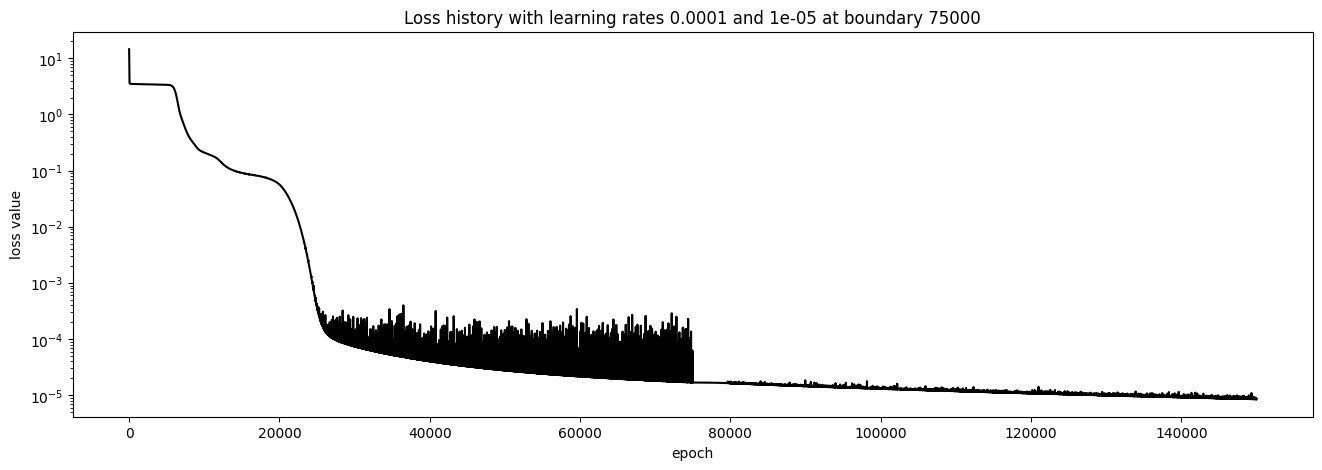

In [16]:
solver.plot_loss_history()

loss_file = f"nn_{NP_train}train_{NP_coll}coll_{int((EPOCHS - 1)//1e3)}Kep_loss_{ODE_MODEL}ODE_init({X0},{V0})_Drange{int(DATA_RANGE*100)}_arch{LENGTH}.png"
outfolder = os.path.join(plots_folder_list[1], loss_file)
plt.title(f'Loss history with learning rates {lr1} and {lr2} at boundary {boundary}')
plt.savefig(outfolder)

Model: "nn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ scale_layer (Lambda)            │ (60, 1)                │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_1 (Dense)          │ (60, 32)               │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_2 (Dense)          │ (60, 32)               │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_3 (Dense)          │ (60, 32)               │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (60, 2)                │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,242 (8.76 KB)

 Trainable params: 2,242 (8.76 KB)

 Non-trainable params: 0 (0.00 B)

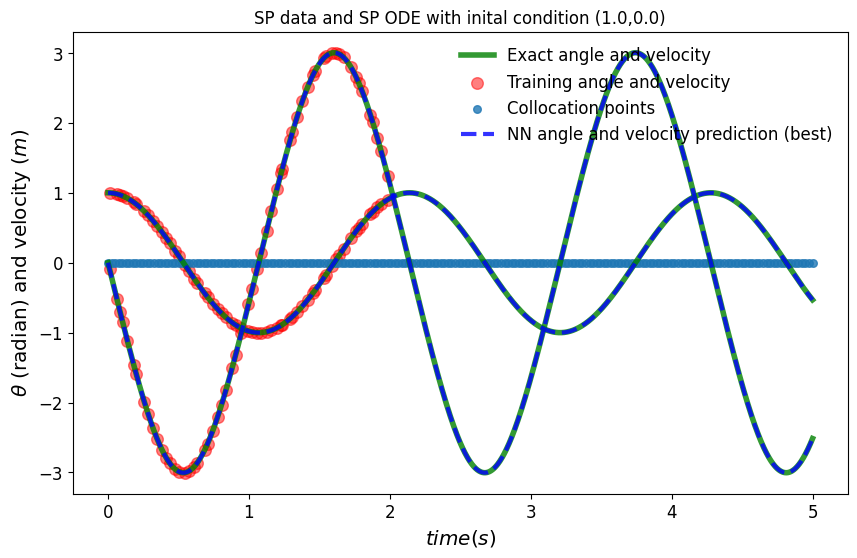

In [17]:
y_pred_final = solver.pinn_model(t_test)

best_model = solver.get_best_model()
y_pred_best = best_model(t_test)
best_model.summary()

plot_results(t_coll_nn, t_train, t_test, y_pred_final, y_train, y_test, y_pred_best=y_pred_best)

png_file = f"nn_{NP_train}train_{NP_coll}coll_{int((EPOCHS - 1)//1e3)}Kep_{ODE_MODEL}ODE_init({X0},{V0})_Drange{int(DATA_RANGE*100)}_arch{LENGTH}.png"
outfolder = os.path.join(plots_folder_list[1], png_file)
plt.title(f'SP data and {ODE_MODEL} ODE with inital condition ({X0},{V0})')
plt.savefig(outfolder)

# More Iterations

In [18]:
solver = pinn_solver(best_model, t_train, t_coll_nn, t_test, y_train, y_test, y_coll)

lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([EPOCHS // 2],[1e-6, 1e-6])
# lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([EPOCHS // 2],[1e-3, 1e-4])
optim = Adam(learning_rate=lr)

solver.train(optimizer=optim, nEpochs=EPOCHS)

epoch 000001: loss = 8.50285778e-06
epoch 003750: loss = 8.33795730e-06
epoch 007500: loss = 8.14023224e-06
epoch 011250: loss = 7.95240339e-06
epoch 015000: loss = 7.76442539e-06
epoch 018750: loss = 7.58793885e-06
epoch 022500: loss = 7.41779377e-06
epoch 026250: loss = 7.25527843e-06
epoch 030000: loss = 7.09702181e-06
epoch 033750: loss = 6.94654818e-06
epoch 037500: loss = 6.80682888e-06
epoch 041250: loss = 6.66125470e-06
epoch 045000: loss = 6.52386780e-06
epoch 048750: loss = 6.39517157e-06
epoch 052500: loss = 6.26724250e-06
epoch 056250: loss = 6.14670762e-06
epoch 060000: loss = 6.02848149e-06
epoch 063750: loss = 5.91287380e-06
epoch 067500: loss = 5.80228561e-06
epoch 071250: loss = 5.69576150e-06
epoch 075000: loss = 5.59233877e-06
epoch 078750: loss = 5.50705408e-06
epoch 082500: loss = 5.39437360e-06
epoch 086250: loss = 5.30031639e-06
epoch 090000: loss = 5.20893946e-06
epoch 093750: loss = 5.11990083e-06
epoch 097500: loss = 5.03359661e-06
epoch 101250: loss = 4.95370

Model: "nn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ scale_layer (Lambda)            │ (60, 1)                │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_1 (Dense)          │ (60, 32)               │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_2 (Dense)          │ (60, 32)               │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_3 (Dense)          │ (60, 32)               │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (60, 2)                │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,242 (8.76 KB)

 Trainable params: 2,242 (8.76 KB)

 Non-trainable params: 0 (0.00 B)

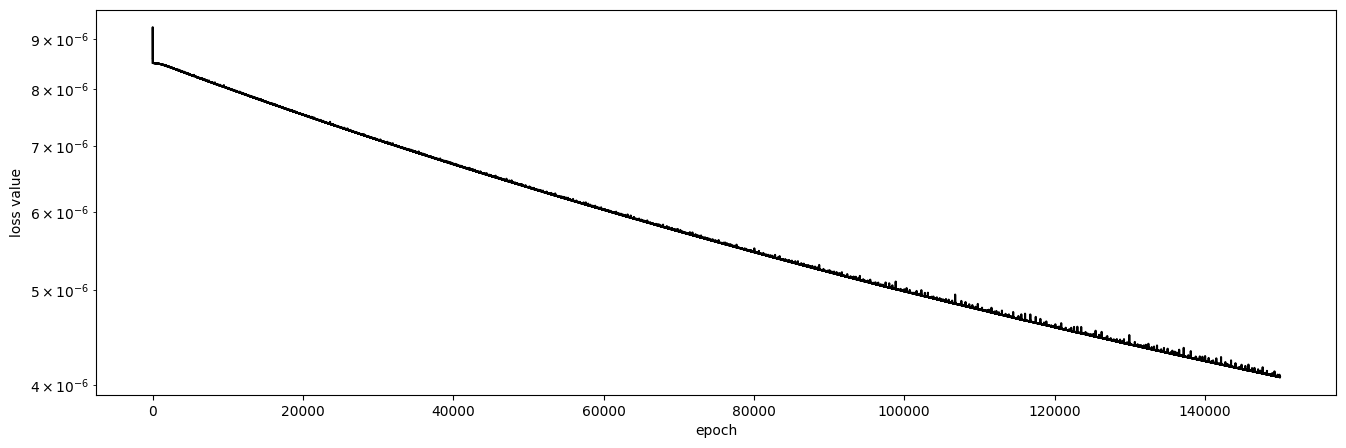

In [19]:
solver.plot_loss_history()

loss_file = f"nn_{NP_train}train_{NP_coll}coll_{int((EPOCHS - 1)//1e3)}Kep_loss.png"
outfolder = os.path.join(plots_folder_list[1], loss_file)
# plt.savefig(outfolder)

x_pred_final = solver.pinn_model(t_test)

best_model = solver.get_best_model()
x_pred_best = best_model(t_test)
best_model.summary()

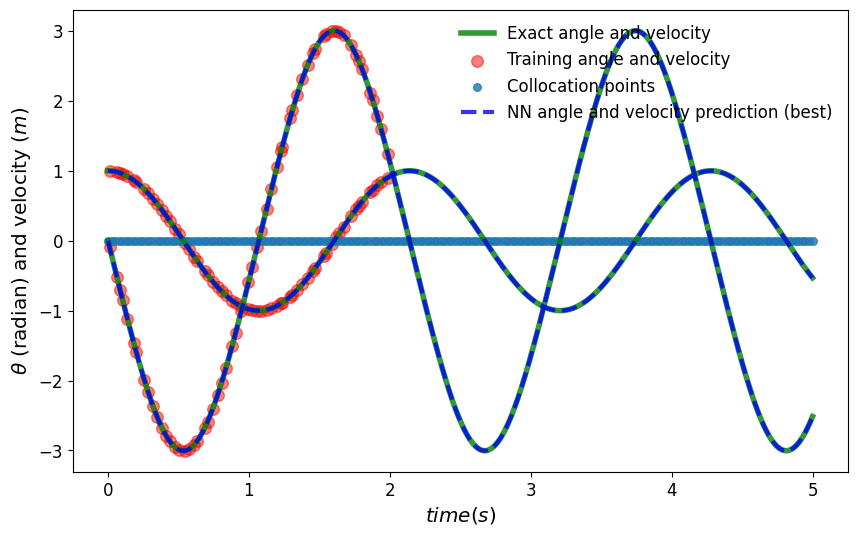

In [20]:
plot_results(t_coll_nn, t_train, t_test, y_pred_final, y_train, y_test, y_pred_best=y_pred_best)

png_file = f"nn_{NP_train}train_{NP_coll}coll_{int((EPOCHS - 1)//1e3)}Kep.png"
outfolder = os.path.join(plots_folder_list[1], png_file)
# plt.savefig(outfolder)